# Linear models (Instructor Notebook)

## **Scikit-Learn Regression Example**

In this example, we train a linear regression model to predict disease progression one year after baseline.

There are ten baseline variables: age, sex, body mass index (BMI), average blood pressure, and six bvlood serum measurements for n = 442 diabetic patients.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()

# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

Split the data set into training and testing sets, by dropping the last 20 observations for the training set (402 observations for training) and keeping the last 20 observations for the testing set (20 observations for testing)

In [ ]:
# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

Create and train the linear regression object, and make predictions

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Traing the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

Output the estimated linear regression coefficients, the mean squared error, and the coefficient of determination (variance score) to understand model fit

Also plot the prediction outputs to visualize model fit

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


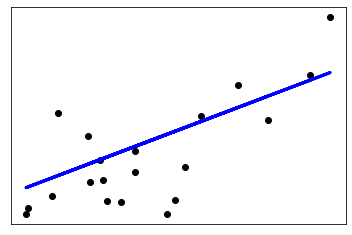

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(diabetes_y_test, diabetes_y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color = 'black')
plt.plot(diabetes_X_test, diabetes_y_pred, color = 'blue', linewidth = 3)

plt.xticks(())
plt.yticks(())

plt.show()

## **Project**

Logistic regression to predict ability of a person to repay a loan

\~\~\~\~\~\~\~\~\~__You only need to run next cell once__\~\~\~\~\~\~\~\~\~

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~\~

In this example, students will explore methods of logistic regression, variable selection, and goodness of fit measures. Using the data from social network, students can build different logistic regression models to obtain the best model fit and explore the parameter space to identify drivers affecting the dependent variable.

The model uses data generated by _randomize_features.py_. Please refer to the code for details. 

In [ ]:
##
# Importing modules and loading the data
# Note that statsmodels are used for logistic regression instead of sklearn
# The main reason - coefficient significant and testing is not available out of the box for sklearn
# There are minor differences in the model specification between logistic regression on statsmodels/sklearn
# See package documentation for more details
##
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression as logit
from sklearn.preprocessing import LabelEncoder as encoder
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/gdrive/My Drive/dscamp/dscamp_public/Linear Models/face_data_inf.csv')
RANDOM_SEED = 123

The dataset contains a number of fields randomized to generate social network profile:

- 'face_id'- id assocated with profile picture
- 'age' - age of a person
- 'gender' - gender of a person
- 'relationship' - marital status (single, married)
- 'music_genre' - favourite musical genre (random, pre-defined list)
- 'band' - random band name based on 'music_genre' (random, non-existant)
- 'team' - favourite team (random, from list of teams)
- 'first_name' - random first name
- 'last_name' - random last name (relationship=='married' adopts the name of the partner)
- 'education' - education level (random conditional on age, pre-defined list)
- 'education_prompt' - technical field for web page render
- 'work'- employer name (if any, otherwise 'unemployed'; random conditional on 'education', non-existant)
- 'work_prompt' - technical field for web page render
- 'fav_movie_1' - favourite movie (random based on genre, pre-defined list)
- 'fav_movie_2' - favourite movie (random based on genre, pre-defined list; disjoint genre from 'fav_movie_1')
- 'fav_book_1' - favourite book (random, pre-defined list)
- 'fav_book_2' - favourite book (random, pre-defined list)
- 'fav_book_3' - favourite book (random, pre-defined list)
- 'fav_auth_1' - favourite book's author (conditional of fav_book_1)
- 'fav_auth_2' - favourite book's author (conditional of fav_book_2)
- 'fav_auth_3' - favourite book's author (conditional of fav_book_3)
- 'fav_food_1' - favourite dish (random, pre-defined list)
- 'fav_food_2' - favourite dish (random, pre-defined list)
- 'fav_food_3' - favourite dish (random, pre-defined list)
- 'home_city' - home town (random US town)
- 'home_state' - home state (based on 'home_city')
- 'languages' - number of languages person speaks (random, 1-4)
- 'hogwarts' - hogwarts house (random, pre-defined list)
- 'fav_pet' - favourite pet (random, pre-defined list)
- 'vg_genre' - favourite video game genre (random, pre-defined list)
- 'fav_video_game' - favourite video game (random, based on 'vg_genre')
- 'spouse_id' - 'face_id' of spouse
- 'n_friends' - number of friends in the network (degree of a node in the social network graph)
- 'credit' - randomly generate binary variable, credit worthiness

Most of the features are completely random, thus are not suitable for regression modeling. Two notable distinctions that can be used for example:

- 'n_friends' - if network is generated using 'config' method, then degree distribution follows the Poisson regression specification:

$$
N_i = exp^{-3+0.1 \textbf{age}_i+0.3 \textbf{relationship}_i+0.1 \textbf{education}_i+0.2 \textbf{languages}_i}+\epsilon_i
$$

where regressors are taken from random dataset (education is binary with 1 for \[bachelor, master, doctor\], 0 otherwise) and $\epsilon$ is a random integer between 1 and 5. Note that the actual degree distribution will be slightly different from the equation due to pre-processing to make a proper graph (with removal of parallel edges and self-loops).

- 'credit' - generated with 'generate_infection' function and assumes the following logistic regression specificaiton:

$$
p_i = \frac{1}{1+\exp^{-(-17+0.4 \textbf{age}_i+ 0.1 \textbf{n_friends}_i -1.5 \textbf{work}_i +1 \textbf{state}_i  + 1.5 \epsilon_i)}}
$$

where regressors are taken from the dataset and $\epsilon$ is a standard normal random variable. 'state' is a discretized variable taking value of 2 if 'home_state' is CA, TX, or FL (highly populous), 1 if 'home_state' is NY, PA, IL, OH, GA, NC (medium populous), and 0 otherwise (low density population states). Variable 'credit' takes value 1 if $p_i>0.5$ and 0 otherwise.

Below we consider reproduced model of logistic regression for 'credit variable'.

In [ ]:
##
# Generate features from the data
##
work = data['work'] == 'unemployed'
work = [float(i) for i in work]

def discretize_state(row):
    if row['home_state'] in ['CA', 'TX', 'FL']:
        return 2
    else:
        if row['home_state'] in ['NY', 'OH', 'IL', 'PA', 'GA', 'NC']:
            return 1
        else:
            return 0


state = data.apply (lambda row: discretize_state(row), axis=1)
data['state'] = state
data['employment'] = work
X = data[['state', 'employment', 'n_friends', 'age']]
y = data['credit']

The logistic regression aims to capture the relationship between financial reliablity/ability to repay debt and a set of social features. The example is motivated by recent efforts to use social network data to infer credit score. The intuitive explanations for the features are as follows:

- 'age' affects repayment rate with higher age being more financially stable. (Note - restricted attribute)
- 'n_friends' having large node degree suggest higher level of responsibility to meet financial obligations.
- 'employment' being unemployed adversely affect the ability to repay one's loan.
- 'state' suggests higher density areas provide bigger opportunities to meet one's financial obligations.

In [ ]:
##
# Split train test into 80/20 ratio.
##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
##
# Fit logistic regression and provide fit summary.
##
lr = sm.Logit(y_train, sm.add_constant(X_train)).fit()
lr.summary()

Optimization terminated successfully.
         Current function value: 0.146478
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 credit   No. Observations:                  800
Model:                          Logit   Df Residuals:                      795
Method:                           MLE   Df Model:                            4
Date:                Wed, 22 Apr 2020   Pseudo R-squ.:                  0.7376
Time:                        15:33:56   Log-Likelihood:                -117.18
converged:                       True   LL-Null:                       -446.54
Covariance Type:            nonrobust   LLR p-value:                3.019e-141
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.8898      2.358     -9.707      0.000     -27.511     -18.268
state          1.5745      0.275      5.731      0.000       1.036       2.113
employment    -2.6158      1.158     -2.259      0.024      -4.886      -0.346
n_friends      0.1144      0.075      1.530      0.126      -0.032       0.261
age            0.5407      0.064      8.415      0.000       0.415       0.667
==============================================================================

Possibly complete quasi-separation: A fraction 0.25 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
##
# Provide accuracy for the model
##
y_pred = lr.predict(sm.add_constant(X_test)) > 0.5
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))